<a href="https://colab.research.google.com/github/nitish-raj/Kaggle-Competitions/blob/main/spp-boosting-fe-optuna-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><p style="text-align: center;"> <u> Song Popularity Prediction </u>  </p> </h1>
<h3><p style="text-align: center;"> <i> Tabular The Data Is </i>  </p> </h3>

<img src="https://i.gifer.com/9mhx.gif" width="500" />

#### *Yeah, you guessed it right, my favourite musician*

In [3]:
!pip install kaggle optuna category_encoders --quiet

In [4]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,roc_auc_score
from xgboost import XGBClassifier,XGBRegressor,plot_importance,XGBRFRegressor

from scipy.stats import mode,boxcox,skew

import matplotlib.pyplot as plt
import optuna
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer,KNNImputer,IterativeImputer
from sklearn.feature_selection import SelectFromModel

from category_encoders import target_encoder
import seaborn as sns
import gc
import sys,os

from scipy.spatial import distance
gc.enable()

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [6]:
!kaggle competitions download -c song-popularity-prediction

  0% 0.00/849k [00:00<?, ?B/s]
100% 849k/849k [00:00<00:00, 25.5MB/s]
  0% 0.00/67.3k [00:00<?, ?B/s]
100% 67.3k/67.3k [00:00<00:00, 59.6MB/s]
  0% 0.00/3.33M [00:00<?, ?B/s]
100% 3.33M/3.33M [00:00<00:00, 83.4MB/s]


In [7]:
!unzip '/content/train.csv.zip'
!unzip '/content/test.csv.zip'

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
unzip:  cannot find or open /content/sample_submission.csv.zip, /content/sample_submission.csv.zip.zip or /content/sample_submission.csv.zip.ZIP.


In [8]:
!rm '/content/test.csv.zip'
!rm '/content/train.csv.zip'

### 1. Read Train, Test and Submission files

In [9]:
# Read Train, Test and Sample Submission Files
def read_data():
    df_train = pd.read_csv("/content/train.csv")
    df_test = pd.read_csv("/content/test.csv")
    df_submission = pd.read_csv("/content/sample_submission.csv")
    return df_train,df_test,df_submission

In [10]:
# Read datasets
df_train,df_test,df_submission = read_data()

#### Let's see how you look.. any missing values.. ANY?

In [11]:
df_train.isna().sum()

id                     0
song_duration_ms    4101
acousticness        3992
danceability        4026
energy              3975
instrumentalness    3985
key                 4065
liveness            4086
loudness            3957
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   song_duration_ms  9043 non-null   float64
 2   acousticness      9050 non-null   float64
 3   danceability      9024 non-null   float64
 4   energy            8945 non-null   float64
 5   instrumentalness  9000 non-null   float64
 6   key               9008 non-null   float64
 7   liveness          8994 non-null   float64
 8   loudness          8974 non-null   float64
 9   audio_mode        10000 non-null  int64  
 10  speechiness       10000 non-null  float64
 11  tempo             10000 non-null  float64
 12  time_signature    10000 non-null  int64  
 13  audio_valence     10000 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 1.1 MB


**Insight**: Both Test and Train have same columns which have NULL values .. Nice

In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,40000.000,19999.500,11547.150,0.000,9999.750,19999.500,29999.250,39999.000
song_duration_ms,35899.000,193165.848,45822.128,25658.000,166254.500,186660.000,215116.000,491671.000
acousticness,36008.000,0.276,0.298,-0.014,0.040,0.141,0.482,1.065
danceability,35974.000,0.571,0.190,0.044,0.425,0.608,0.718,0.957
energy,36025.000,0.684,0.213,-0.002,0.539,0.704,0.871,1.040
instrumentalness,36015.000,0.037,0.150,-0.004,0.001,0.002,0.003,1.075
key,35935.000,5.043,3.373,0.000,2.000,5.000,8.000,11.000
liveness,35914.000,0.199,0.152,0.028,0.112,0.136,0.213,1.065
loudness,36043.000,-7.408,3.877,-32.118,-9.578,-6.345,-4.621,-0.877
audio_mode,40000.000,0.321,0.467,0.000,0.000,0.000,1.000,1.000


In [15]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.000,4999.500,2886.896,0.000,2499.750,4999.500,7499.250,9999.000
song_duration_ms,9043.000,193091.109,46502.320,25377.000,166689.000,186196.000,215059.000,448558.000
acousticness,9050.000,0.280,0.300,-0.014,0.042,0.142,0.493,1.046
danceability,9024.000,0.570,0.190,0.065,0.427,0.606,0.715,0.947
energy,8945.000,0.684,0.213,0.021,0.542,0.700,0.871,1.031
instrumentalness,9000.000,0.037,0.151,-0.003,0.001,0.002,0.003,1.021
key,9008.000,5.013,3.387,0.000,2.000,5.000,8.000,11.000
liveness,8994.000,0.196,0.149,0.035,0.112,0.136,0.209,1.004
loudness,8974.000,-7.422,3.903,-29.887,-9.655,-6.346,-4.605,-0.879
audio_mode,10000.000,0.324,0.468,0.000,0.000,0.000,1.000,1.000


### What does each variable mean?
> - **Instrumentalness:** This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.
> - **Acousticness:** This value describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
> - **Liveness:** This value describes the probability that the song was recorded with a live audience. According to the official documentation “a value above 0.8 provides strong likelihood that the track is live”.
> - **Speechiness:** “Speechiness detects the presence of spoken words in a track”. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.
> - **Energy:** “(energy) represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy”.
> - **Danceability:** “Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable”.
> - **Valence:** “A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)”
> - **Song Duration ms :** Duration of song in milliseconds
> - **Audio Mode :** No specific description
> - **Tempo :** Tempo (Italian for "time"; plural tempos, or tempi from the Italian plural) is the speed or pace of a given piece.For example, a tempo of 60 beats per minute signifies one beat per second, while a tempo of 120 beats per minute is twice as rapid, signifying one beat every 0.5 seconds
> - **Time Signature :** The time signature indicates how many counts are in each measure and which type of note will receive one count. The top number is commonly 2, 3, 4, or 6.The bottom number is either 4 or 8. Simple time signatures divide music into groups of 2 and compound divide music into groups of 3.
> - **Loudness:** Loudness measures the decibel level of a song. Decibels are relative to a reference value, so songs with lower loudness values are quieter relative to the reference value of 0.
> - **Danceability:** Danceability quantifies how suitable a track is for dancing based on a combination of musical elements, like tempo, rhythm, and beat. Songs with higher danceability have stronger and more regular beats.Like acousticness, danceability is measured on a scale of 0 (low danceability) to 100 (high danceability).

In [40]:
cont_cols = [col for col in df_train.columns if col not in ['id','song_popularity','audio_mode','time_signature','key']]
cat_cols = ['audio_mode','time_signature','key']

In [17]:
print(f'% Distribution of Song Popularity:\n{(df_train.song_popularity.value_counts())/len(df_train.song_popularity)*100}')

% Distribution of Song Popularity:
0   63.560
1   36.440
Name: song_popularity, dtype: float64


In [18]:
df_train.key.value_counts()

0.000     5175
6.000     4949
10.000    4302
2.000     4080
8.000     3028
5.000     2985
9.000     2881
7.000     2690
4.000     2239
1.000     2143
3.000     1346
11.000     117
Name: key, dtype: int64

In [19]:
df_train.audio_mode.value_counts()

0    27154
1    12846
Name: audio_mode, dtype: int64

In [20]:
df_train.time_signature.value_counts()

3    23358
4    15919
2      530
5      193
Name: time_signature, dtype: int64

### 2. Plot the distribution of data for each column

![Alt text](https://media.makeameme.org/created/if-you-didnt-58c83d63de.jpg)

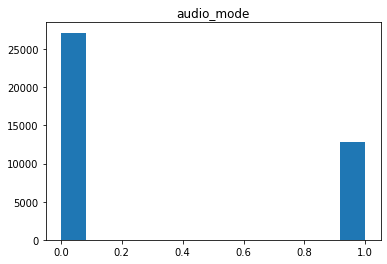

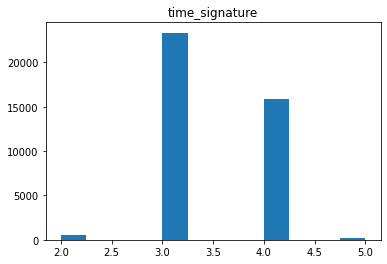

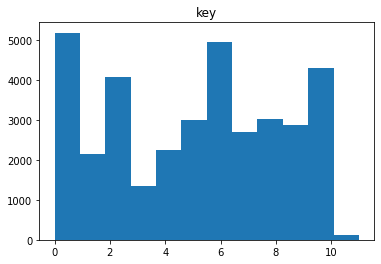

In [21]:
for col in cat_cols:
    df_train.hist(col,grid=False,bins = 12)

> **I NEED SOME CHARTS.. NOW**

Hmm... Below plots will show the distribution of data against our target variables.. Please be nice

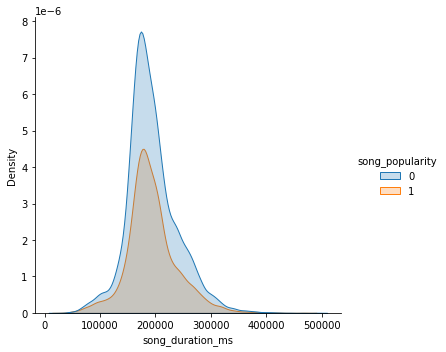

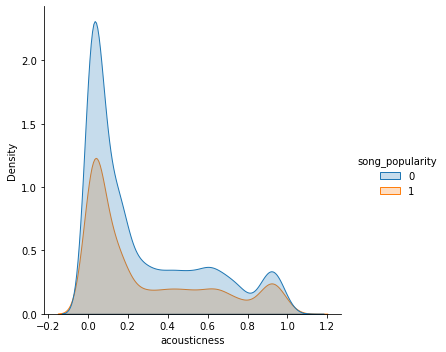

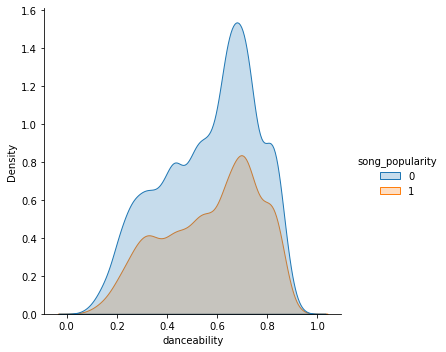

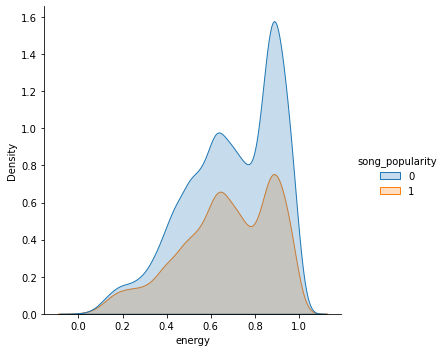

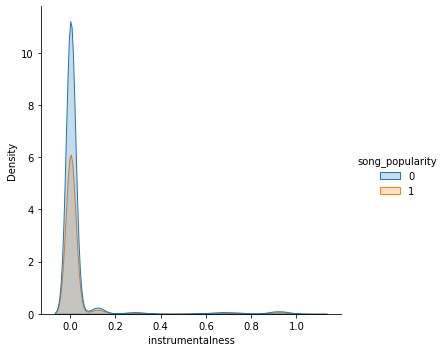

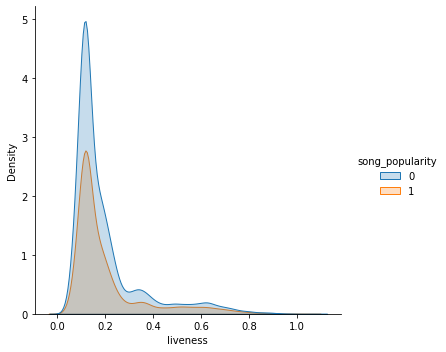

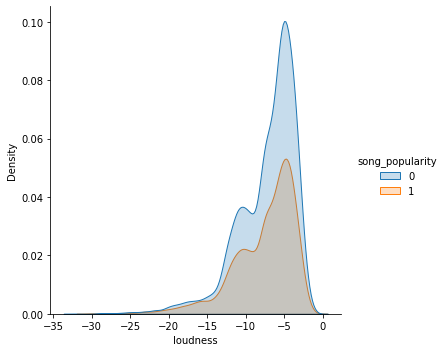

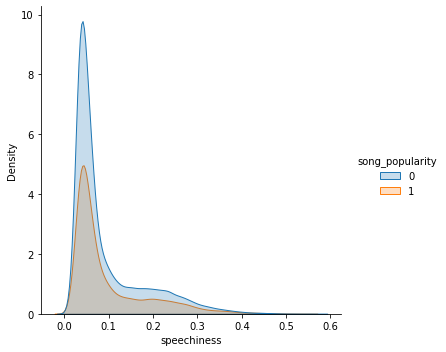

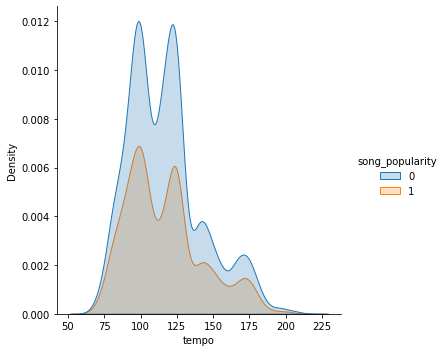

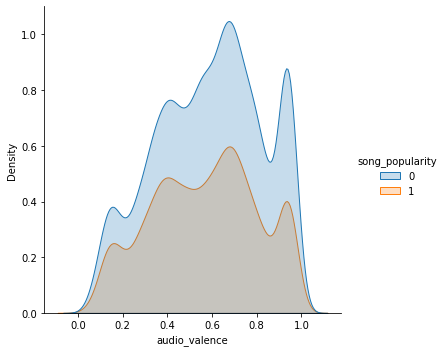

In [22]:
for col in cont_cols:
    sns.displot(data=df_train, x=col,hue="song_popularity",kind = "kde", fill=True)

> Let's check box plots for those.. outliers

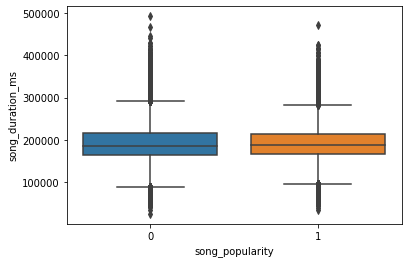

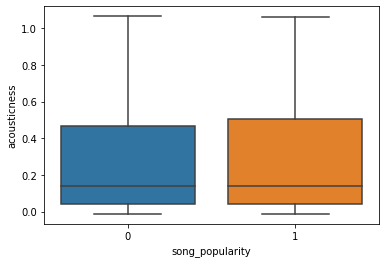

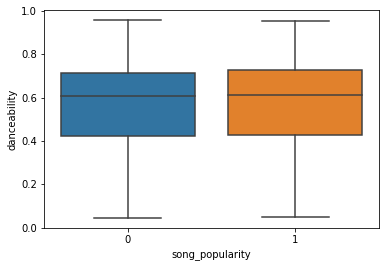

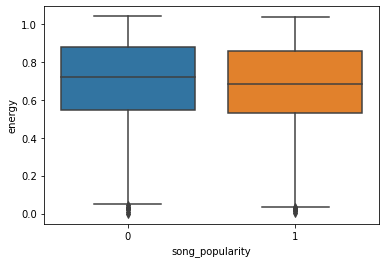

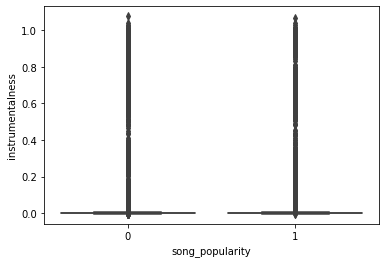

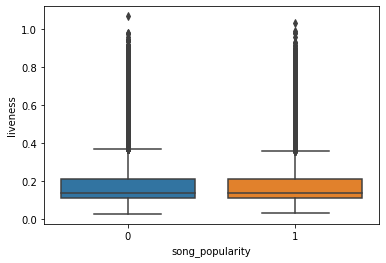

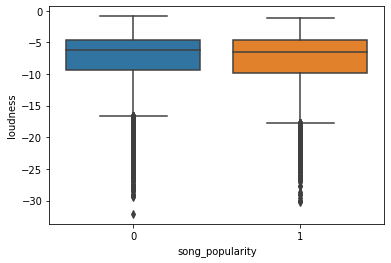

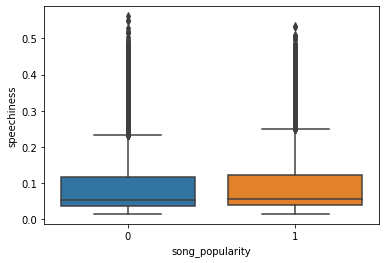

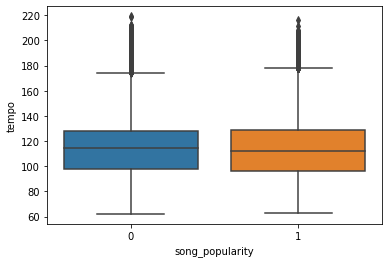

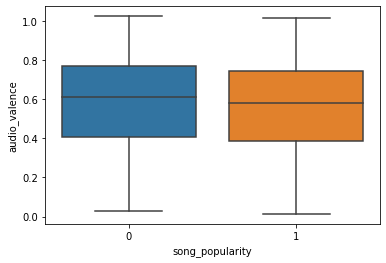

In [23]:
for col in cont_cols:
    plt.figure()
    sns.boxplot(data = df_train,x='song_popularity',y = col)

### I know my visualization skills need a serious upgrade

#### *Working..... On it........*

In [24]:
# Check correlation between the columns
corr = df_train.drop(['id','song_popularity'],axis=1).corr()
cm = sns.light_palette("green", as_cmap=True)
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
corr.style.background_gradient(cmap=cm)

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_duration_ms,1.000000,-0.166443,-0.061929,0.148531,-0.024337,0.019354,0.033009,0.152954,-0.017211,-0.001236,0.085490,0.021609,-0.006948
acousticness,-0.166443,1.000000,-0.093737,-0.570177,0.072516,-0.186663,-0.124704,-0.532724,0.066973,-0.130244,-0.190964,-0.205307,-0.250310
danceability,-0.061929,-0.093737,1.000000,0.099933,-0.146447,0.120514,0.045400,0.200148,0.030289,0.177937,-0.089887,0.016455,0.384496
energy,0.148531,-0.570177,0.099933,1.000000,-0.120338,0.210176,0.154907,0.643931,-0.094916,0.120053,0.225465,0.238722,0.324626
instrumentalness,-0.024337,0.072516,-0.146447,-0.120338,1.000000,-0.054726,-0.033445,-0.181889,-0.003617,-0.053209,-0.010350,-0.047397,-0.157760
key,0.019354,-0.186663,0.120514,0.210176,-0.054726,1.000000,0.077046,0.201509,-0.036252,0.102993,0.053206,0.094144,0.132194
liveness,0.033009,-0.124704,0.045400,0.154907,-0.033445,0.077046,1.000000,0.146551,-0.013281,0.076612,0.064425,0.037766,0.084770
loudness,0.152954,-0.532724,0.200148,0.643931,-0.181889,0.201509,0.146551,1.000000,-0.076893,0.157550,0.173979,0.245403,0.356330
audio_mode,-0.017211,0.066973,0.030289,-0.094916,-0.003617,-0.036252,-0.013281,-0.076893,1.000000,0.019790,-0.023202,-0.043714,-0.015683
speechiness,-0.001236,-0.130244,0.177937,0.120053,-0.053209,0.102993,0.076612,0.157550,0.019790,1.000000,0.036192,0.035013,0.112558


> **Let's Create a function below to Scale our data**

In [25]:
# Function to Scale and transform dataset
def data_scaler_fit(option,df):
    if option == 1:
        transformer = StandardScaler().fit(df)
    if option == 2 :
        transformer = RobustScaler().fit(df)
    if option == 3 :
        transformer = MinMaxScaler().fit(df)
    if option == 4 :
        transformer = PowerTransformer(method = 'yeo-johnson').fit(df)
    return transformer

> **A Function to remove outlier, the standard way**

In [26]:
# Function to Remove outliers
def remove_outliers(x,method):
    if method == 'mean':
        upper_limit = x.mean() + (3*x.std())
        lower_limit = x.mean() - (3*x.std())
        return np.where(x > upper_limit,upper_limit,np.where(x <lower_limit,lower_limit,x))
    elif method == 'median':
        upper_limit = x.median() + (1.5*x.quantile(0.75))
        lower_limit = x.median() - (1.5*x.quantile(0.25))
        return np.where(x > upper_limit,upper_limit,np.where(x <lower_limit,lower_limit,x))
    else:
        return x

In [27]:
def imputations(impute_method,method=None):
    if impute_method == 'knn':
        imputer = KNNImputer(n_neighbors = 10,weights = 'distance')
    if impute_method == 'iter':
        imputer = IterativeImputer(max_iter=20)
    if impute_method == 'simple':
        imputer = SimpleImputer(strategy=method)
    if impute_method == 'lgbm':
        if not os.path.exists("kuma_utils/"):
            !git clone https://github.com/analokmaus/kuma_utils.git
        sys.path.append("kuma_utils/")
        from kuma_utils.preprocessing.imputer import LGBMImputer
        imputer = LGBMImputer(n_iter=300, verbose=False)
    return imputer

### 3. Let's Transform those features, one at a time

> 1. Column **Key**,**audio_mode**,**time_signature**  seems to be categorical, hence replacing null values using KNN
> 2. Convert **time_signature** from milliseconds to minutes
> 3. Fill Rest of the columns which has null values using mean of the columns (Might replace with something better)
> 4. Use Boxcox transform to reduce skewness in continuous columns
> 5. Finally using StandarScaler on all continuous columns : *It transforms the data in such a manner that it has mean as 0 and standard deviation as 1*

In [39]:
def feature_transform(df,option,method):
    ids = df.id.values.tolist()
    
    # Replace missing values for continuous columns
    impute = imputations(impute_method)
    
    df_temp = pd.DataFrame(impute.fit_transform(pd.concat([df[cat_cols],df[cont_cols]],axis = 1)))
    
    df_temp.columns = cat_cols + cont_cols
    
    df_cat = df_temp[cat_cols].copy()
    df_cont = df_temp[cont_cols].copy()
    
    # Decreasing data skewness for continuos variables using BoxCox
    df_cont['golden_ratio'] = (df_cont['song_duration_ms'] / 1000) * 0.618033
    df_cont['song_duration_ms'] = boxcox(df_cont.song_duration_ms/60000)[0]
    
    df_cont['instrumentalness_main'] = np.where(df_cont['instrumentalness']<=0.01,df_cont['instrumentalness'],0)
    df_cont['instrumentalness_side'] = np.where(df_cont['instrumentalness']>0.2,df_cont['instrumentalness'],0)
    df_cont.drop('instrumentalness',axis =1 ,inplace=True)
    #df_cont['instrumentalness_side'] = boxcox((df_cont.instrumentalness_side)+0.005)[0]
    #df_cont['instrumentalness_main'] = boxcox((df_cont.instrumentalness_main)+0.2)[0]
    
    
    #df_cont['acousticness'] = boxcox(df_cont.acousticness + 0.2)[0]
    
    df_cont['liveness_main'] = np.where(df_cont['liveness']<0.8,df_cont['liveness'],0)
    df_cont['liveness_side'] = np.where(df_cont['liveness']>=0.8,df_cont['liveness'],0)
    df_cont.drop('liveness',axis =1 ,inplace=True)
    #df_cont['liveness']  = boxcox(df_cont.liveness + 0.04)[0]    
    
    #df_cont['loudness'] = boxcox(df_cont.loudness + 100)[0] 
    #df_cont['energy'] = boxcox(df_cont.energy+0.2)[0]
    #df_cont['danceability'] = boxcox(df_cont.danceability)[0]
  
    
    df_cont['speechiness_sw'] = np.where(df_cont['speechiness']>0.66,df_cont['speechiness'],0)
    df_cont['speechiness_mw'] = np.where((df_cont['speechiness']<=0.66) & (df_cont['speechiness']>=0.33),df_cont['speechiness'],0)
    df_cont['speechiness_m'] = np.where(df_cont['speechiness']<0.33,df_cont['speechiness'],0)
    #df_cont['speechiness'] = boxcox(df_cont.speechiness)[0]
    df_cont.drop('speechiness',axis =1 ,inplace=True)
    
    
    #df_cont['tempo'] = boxcox(df_cont.tempo)[0]
    
    # Normalise Continuous columns
    transformer = data_scaler_fit(option,df_cont)
    df_cont = pd.DataFrame(transformer.transform(df_cont.apply(lambda x: remove_outliers(x,method))))
    
    df_cont.columns = [x for x in cont_cols if (x not in ['instrumentalness','liveness','speechiness'])] + ['golden_ratio','instrumentalness_main','instrumentalness_side','liveness_main','liveness_side','speechiness_sw','speechiness_mw','speechiness_m']
    
    df = pd.concat([df_cont,df_cat.reset_index(drop=True)],axis = 1)
    
    df['id'] = ids
    
    return df

In [33]:
# Initialize Static values
random_state = 151
early_stopping_rounds=1500
verbose = 2000
n_estimators = 15000
n_splits = 5
method = 'mean'
scaling_option = 4
impute_method = 'lgbm'

### 4. Using Optuna for Hyperparameter Tuning

In [34]:
df_train,df_test,df_submission = read_data()

y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


def objective(trial):
    # XGBoost parameters
    
    gc.collect()
    
    final_valid_predictions = {}
    
    scores = []
    auc_score = []
    
    params = {
        "objective": "binary:logistic",
        "n_estimators": n_estimators,
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.9),
        "subsample": trial.suggest_loguniform("subsample", 0.2, 0.9),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 100.0),
        "lambda": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "gamma": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 100),
        "n_jobs": -1,
        "tree_method": "gpu_hist",
        "predictor" : "gpu_predictor",
    }
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
        xtrain, ytrain = X.iloc[idx_train], y[idx_train]
        xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]

        # Store IDs of validation Dataset
        valid_ids = xvalid.id.values.tolist()

        #Save a copy of yvalid
        true_valid = yvalid

        n_class = len(np.unique(ytrain))

        xtrain = feature_transform(xtrain,scaling_option,method)
        xvalid = feature_transform(xvalid,scaling_option,method)
        
        xtrain = xtrain.drop('id',axis = 1)
        xvalid = xvalid.drop('id',axis = 1)
        
        
        model = XGBRegressor(
            random_state = random_state,
            sampling_method = 'gradient_based',
            use_label_encoder=False,
            eval_metric = ['auc'],
            **params
        )
        model.fit(xtrain, ytrain,early_stopping_rounds=early_stopping_rounds, eval_set=[(xvalid, yvalid)], verbose=verbose)

        preds_valid = model.predict(xvalid)
        
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        auc_scr = roc_auc_score(true_valid, preds_valid)

        auc_score.append(auc_scr)

        print(f"Fold {fold+1} || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    return roc_auc_score(y.to_numpy(), np.array(sorted(final_valid_predictions.items()))[:,1])

![alt text](https://miro.medium.com/max/900/1*80wf6AeqTLD9ntyFxYMuLw.jpeg)

### Keep Calm .. Optuna is Studying....

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-01-29 12:53:26,327] A new study created in memory with name: no-name-6c9baa3e-bbfc-43b6-98b2-8aadde3159cb


[0]	validation_0-aucpr:0.385033	validation_0-auc:0.526946
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[141]	validation_0-aucpr:0.421706	validation_0-auc:0.574946

Fold 1 || AUC : 0.5749454808563174 || Mean AUC : 0.5749454808563174
[0]	validation_0-aucpr:0.397025	validation_0-auc:0.540494
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[229]	validation_0-aucpr:0.434143	validation_0-auc:0.574323

Fold 2 || AUC : 0.5743226217762869 || Mean AUC : 0.5746340513163022
[0]	validation_0-aucpr:0.39639	validation_0-auc:0.536529
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[76]	validatio

[I 2022-01-29 13:00:43,580] Trial 0 finished with value: 0.5531909347110762 and parameters: {'max_depth': 7, 'learning_rate': 0.02018905379042377, 'colsample_bytree': 0.5620882297462233, 'subsample': 0.22328964776023588, 'alpha': 8.592437220029616, 'lambda': 9.799022854109, 'min_child_weight': 44.90795478765651}. Best is trial 0 with value: 0.5531909347110762.


Fold 5 || AUC : 0.5725298861162647 || Mean AUC : 0.574066302465996
[0]	validation_0-aucpr:0.37706	validation_0-auc:0.518911
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[72]	validation_0-aucpr:0.400874	validation_0-auc:0.551481

Fold 1 || AUC : 0.55148104858908 || Mean AUC : 0.55148104858908
[0]	validation_0-aucpr:0.385501	validation_0-auc:0.531686
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[38]	validation_0-aucpr:0.396128	validation_0-auc:0.545507

Fold 2 || AUC : 0.5455065262746011 || Mean AUC : 0.5484937874318405
[0]	validation_0-aucpr:0.38844	validation_0-auc:0.532864
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't impro

[I 2022-01-29 13:13:22,388] Trial 1 finished with value: 0.5455871358100318 and parameters: {'max_depth': 10, 'learning_rate': 0.3135703489237973, 'colsample_bytree': 0.27391280708674864, 'subsample': 0.5098802621397843, 'alpha': 4.779765781407182, 'lambda': 14.648069354340956, 'min_child_weight': 16.699361241015264}. Best is trial 0 with value: 0.5531909347110762.


Fold 5 || AUC : 0.5450542342689456 || Mean AUC : 0.5456359997013497
[0]	validation_0-aucpr:0.382812	validation_0-auc:0.528953
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.424669	validation_0-auc:0.574645
Stopping. Best iteration:
[920]	validation_0-aucpr:0.423627	validation_0-auc:0.575486

Fold 1 || AUC : 0.575485865500893 || Mean AUC : 0.575485865500893
[0]	validation_0-aucpr:0.388124	validation_0-auc:0.533468
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.426359	validation_0-auc:0.569998
Stopping. Best iteration:
[997]	validation_0-aucpr:0.427655	validation_0-auc:0.571608

Fold 2 || AUC : 0.5716078804407407 || Mean AUC : 0.5735468729708169
[0]	validation_0-aucpr:0.390084	validation_0-auc:0.537057
Multiple e

[I 2022-01-29 13:32:09,483] Trial 2 finished with value: 0.5717887336589229 and parameters: {'max_depth': 13, 'learning_rate': 0.006118774782063431, 'colsample_bytree': 0.2240283997683686, 'subsample': 0.5114276650016389, 'alpha': 5.940939518009918, 'lambda': 0.8679115113814506, 'min_child_weight': 79.39709426007515}. Best is trial 2 with value: 0.5717887336589229.


Fold 5 || AUC : 0.5734563314370699 || Mean AUC : 0.5729272106365659
[0]	validation_0-aucpr:0.392161	validation_0-auc:0.540204
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.426391	validation_0-auc:0.576214
Stopping. Best iteration:
[1660]	validation_0-aucpr:0.426288	validation_0-auc:0.576999

Fold 1 || AUC : 0.5769987738463277 || Mean AUC : 0.5769987738463277
[0]	validation_0-aucpr:0.391981	validation_0-auc:0.538651
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.433416	validation_0-auc:0.57702
Stopping. Best iteration:
[1604]	validation_0-aucpr:0.433954	validation_0-auc:0.577799

Fold 2 || AUC : 0.5777988264680534 || Mean AUC : 0.5773988001571906
[0]	validation_0-aucpr:0.381474	validation_0-auc:0.527322
Multipl

[I 2022-01-29 13:47:09,451] Trial 3 finished with value: 0.5732318112042589 and parameters: {'max_depth': 6, 'learning_rate': 0.0028612827890369804, 'colsample_bytree': 0.5648980164180035, 'subsample': 0.3442948823006474, 'alpha': 2.2815441849938503, 'lambda': 5.079005661345978, 'min_child_weight': 46.7011831393325}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5761018051737665 || Mean AUC : 0.5751978618738336
[0]	validation_0-aucpr:0.393324	validation_0-auc:0.539227
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[22]	validation_0-aucpr:0.416275	validation_0-auc:0.57006

Fold 1 || AUC : 0.5700597560173449 || Mean AUC : 0.5700597560173449
[0]	validation_0-aucpr:0.392087	validation_0-auc:0.529063
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[9]	validation_0-aucpr:0.423448	validation_0-auc:0.565062

Fold 2 || AUC : 0.5650619064244042 || Mean AUC : 0.5675608312208746
[0]	validation_0-aucpr:0.392507	validation_0-auc:0.542843
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't 

[I 2022-01-29 14:04:58,680] Trial 4 finished with value: 0.5634768411171341 and parameters: {'max_depth': 15, 'learning_rate': 0.35384976829262205, 'colsample_bytree': 0.544901877822831, 'subsample': 0.803680070465578, 'alpha': 14.375139305661921, 'lambda': 0.021259096951404592, 'min_child_weight': 79.68854157320402}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5642852006725961 || Mean AUC : 0.5641270283789607
[0]	validation_0-aucpr:0.382446	validation_0-auc:0.524248
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[142]	validation_0-aucpr:0.426007	validation_0-auc:0.578047

Fold 1 || AUC : 0.5780471268031796 || Mean AUC : 0.5780471268031796
[0]	validation_0-aucpr:0.382973	validation_0-auc:0.530232
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[88]	validation_0-aucpr:0.42458	validation_0-auc:0.573067

Fold 2 || AUC : 0.5730669527129704 || Mean AUC : 0.5755570397580749
[0]	validation_0-aucpr:0.382932	validation_0-auc:0.532614
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn'

[I 2022-01-29 14:14:26,924] Trial 5 finished with value: 0.5719443801188916 and parameters: {'max_depth': 2, 'learning_rate': 0.26796163422944114, 'colsample_bytree': 0.37798375360777786, 'subsample': 0.4906381277481375, 'alpha': 0.01081189338651571, 'lambda': 57.22484188916922, 'min_child_weight': 10.55016596703666}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5728361941873102 || Mean AUC : 0.5722655982877
[0]	validation_0-aucpr:0.392735	validation_0-auc:0.535441
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[11]	validation_0-aucpr:0.409153	validation_0-auc:0.562554

Fold 1 || AUC : 0.5625535704346858 || Mean AUC : 0.5625535704346858
[0]	validation_0-aucpr:0.386631	validation_0-auc:0.529508
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[45]	validation_0-aucpr:0.416115	validation_0-auc:0.555544

Fold 2 || AUC : 0.5555443228410335 || Mean AUC : 0.5590489466378596
[0]	validation_0-aucpr:0.382762	validation_0-auc:0.523862
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't i

[I 2022-01-29 14:23:26,684] Trial 6 finished with value: 0.5524303639041461 and parameters: {'max_depth': 7, 'learning_rate': 0.22907716674691317, 'colsample_bytree': 0.517684214473816, 'subsample': 0.34724749864282517, 'alpha': 0.4479290403703811, 'lambda': 29.65903376215213, 'min_child_weight': 10.618727649490614}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5576967440821361 || Mean AUC : 0.5538865611299111
[0]	validation_0-aucpr:0.377733	validation_0-auc:0.51472
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[204]	validation_0-aucpr:0.418541	validation_0-auc:0.570157

Fold 1 || AUC : 0.5701570050142433 || Mean AUC : 0.5701570050142433
[0]	validation_0-aucpr:0.385891	validation_0-auc:0.531849
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[106]	validation_0-aucpr:0.42463	validation_0-auc:0.569652

Fold 2 || AUC : 0.5696519376432551 || Mean AUC : 0.5699044713287491
[0]	validation_0-aucpr:0.385625	validation_0-auc:0.526698
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn'

[I 2022-01-29 14:30:14,195] Trial 7 finished with value: 0.5680199167886519 and parameters: {'max_depth': 10, 'learning_rate': 0.05504640927519514, 'colsample_bytree': 0.27472564866093757, 'subsample': 0.20067709562845693, 'alpha': 87.10923556015301, 'lambda': 37.859714044386756, 'min_child_weight': 73.98422206568227}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5659990014127542 || Mean AUC : 0.5707518510962479
[0]	validation_0-aucpr:0.401407	validation_0-auc:0.546422
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.423204	validation_0-auc:0.574324
[4000]	validation_0-aucpr:0.42544	validation_0-auc:0.574884
Stopping. Best iteration:
[2785]	validation_0-aucpr:0.425285	validation_0-auc:0.575475

Fold 1 || AUC : 0.5754745315907446 || Mean AUC : 0.5754745315907446
[0]	validation_0-aucpr:0.393138	validation_0-auc:0.539444
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.430486	validation_0-auc:0.576838
Stopping. Best iteration:
[2326]	validation_0-aucpr:0.430837	validation_0-auc:0.577119

Fold 2 || AUC : 0.5771187243953982 || Mean AUC : 0.5762966279930715
[0]	

[I 2022-01-29 14:59:06,805] Trial 8 finished with value: 0.5677867688913696 and parameters: {'max_depth': 9, 'learning_rate': 0.0013293691698446398, 'colsample_bytree': 0.825242048613877, 'subsample': 0.5520040081461791, 'alpha': 0.07913465146726664, 'lambda': 0.16435193380256982, 'min_child_weight': 75.67505046926725}. Best is trial 3 with value: 0.5732318112042589.


Fold 5 || AUC : 0.5754488853381166 || Mean AUC : 0.5749348128318443
[0]	validation_0-aucpr:0.382558	validation_0-auc:0.526888
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.416031	validation_0-auc:0.563113
Stopping. Best iteration:
[526]	validation_0-aucpr:0.426767	validation_0-auc:0.576708

Fold 1 || AUC : 0.5767076340293906 || Mean AUC : 0.5767076340293906
[0]	validation_0-aucpr:0.386014	validation_0-auc:0.52983
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[215]	validation_0-aucpr:0.430437	validation_0-auc:0.576945

Fold 2 || AUC : 0.5769454774831299 || Mean AUC : 0.5768265557562602
[0]	validation_0-aucpr:0.377516	validation_0-auc:0.515211
Multiple eval metrics have been passed: 'validation_0-auc' will be use

[I 2022-01-29 15:07:42,903] Trial 9 finished with value: 0.5752742367061661 and parameters: {'max_depth': 2, 'learning_rate': 0.08112136156406079, 'colsample_bytree': 0.8974962261420038, 'subsample': 0.3652185340144505, 'alpha': 0.10039378409322294, 'lambda': 2.2894234844838715, 'min_child_weight': 14.144829984795372}. Best is trial 9 with value: 0.5752742367061661.


Fold 5 || AUC : 0.5782515940701023 || Mean AUC : 0.5753639351915206
[0]	validation_0-aucpr:0.382315	validation_0-auc:0.527907
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[477]	validation_0-aucpr:0.420843	validation_0-auc:0.57275

Fold 1 || AUC : 0.5727500754750713 || Mean AUC : 0.5727500754750713
[0]	validation_0-aucpr:0.38515	validation_0-auc:0.526879
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[252]	validation_0-aucpr:0.431272	validation_0-auc:0.577599

Fold 2 || AUC : 0.5775986615191824 || Mean AUC : 0.5751743684971269
[0]	validation_0-aucpr:0.383592	validation_0-auc:0.529428
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn'

[I 2022-01-29 15:14:37,860] Trial 10 finished with value: 0.5743411971708452 and parameters: {'max_depth': 2, 'learning_rate': 0.04968874701644393, 'colsample_bytree': 0.8915237553497591, 'subsample': 0.2740044195748091, 'alpha': 0.24440596514093071, 'lambda': 1.0625571964493088, 'min_child_weight': 20.75524239508214}. Best is trial 9 with value: 0.5752742367061661.


Fold 5 || AUC : 0.5774612369530704 || Mean AUC : 0.5744500471278429
[0]	validation_0-aucpr:0.381244	validation_0-auc:0.526666
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.417757	validation_0-auc:0.565702
Stopping. Best iteration:
[607]	validation_0-aucpr:0.426426	validation_0-auc:0.57486

Fold 1 || AUC : 0.5748600380158236 || Mean AUC : 0.5748600380158236
[0]	validation_0-aucpr:0.3847	validation_0-auc:0.526593
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.424335	validation_0-auc:0.568728
Stopping. Best iteration:
[898]	validation_0-aucpr:0.428971	validation_0-auc:0.575327

Fold 2 || AUC : 0.5753267185125592 || Mean AUC : 0.5750933782641914
[0]	validation_0-aucpr:0.383592	validation_0-auc:0.529428
Multiple ev

[I 2022-01-29 15:22:13,637] Trial 11 finished with value: 0.5738156375554461 and parameters: {'max_depth': 2, 'learning_rate': 0.0591551977398964, 'colsample_bytree': 0.8807676123907803, 'subsample': 0.2828946367072455, 'alpha': 0.22237145739624567, 'lambda': 1.041407936186795, 'min_child_weight': 20.567297866407166}. Best is trial 9 with value: 0.5752742367061661.


Fold 5 || AUC : 0.5788100447462061 || Mean AUC : 0.5740496979953206
[0]	validation_0-aucpr:0.378742	validation_0-auc:0.523264
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[172]	validation_0-aucpr:0.426751	validation_0-auc:0.57356

Fold 1 || AUC : 0.573559910340675 || Mean AUC : 0.573559910340675
[0]	validation_0-aucpr:0.393013	validation_0-auc:0.534066
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[129]	validation_0-aucpr:0.431492	validation_0-auc:0.57461

Fold 2 || AUC : 0.5746103884056797 || Mean AUC : 0.5740851493731773
[0]	validation_0-aucpr:0.396672	validation_0-auc:0.543249
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't 

[I 2022-01-29 15:29:17,957] Trial 12 finished with value: 0.5713963597798462 and parameters: {'max_depth': 4, 'learning_rate': 0.059022650468211625, 'colsample_bytree': 0.719115189477983, 'subsample': 0.27189956850248354, 'alpha': 0.04356736991344555, 'lambda': 1.6186206160848116, 'min_child_weight': 20.285270739483195}. Best is trial 9 with value: 0.5752742367061661.


Fold 5 || AUC : 0.5779618459267031 || Mean AUC : 0.5740495204272639
[0]	validation_0-aucpr:0.400545	validation_0-auc:0.547963
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.421589	validation_0-auc:0.569722
Stopping. Best iteration:
[562]	validation_0-aucpr:0.424448	validation_0-auc:0.575961

Fold 1 || AUC : 0.5759613837489943 || Mean AUC : 0.5759613837489943
[0]	validation_0-aucpr:0.389051	validation_0-auc:0.537727
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[401]	validation_0-aucpr:0.435555	validation_0-auc:0.578654

Fold 2 || AUC : 0.5786540981698771 || Mean AUC : 0.5773077409594357
[0]	validation_0-aucpr:0.394679	validation_0-auc:0.545625
Multiple eval metrics have been passed: 'validation_0-auc' will be us

[I 2022-01-29 15:39:20,801] Trial 13 finished with value: 0.5752849847162919 and parameters: {'max_depth': 4, 'learning_rate': 0.016977517733337267, 'colsample_bytree': 0.6896661836124399, 'subsample': 0.37579168442366084, 'alpha': 0.6671699355467844, 'lambda': 0.22552580112043674, 'min_child_weight': 28.40758754663565}. Best is trial 13 with value: 0.5752849847162919.


Fold 5 || AUC : 0.5789150367110999 || Mean AUC : 0.5754645784380505
[0]	validation_0-aucpr:0.390845	validation_0-auc:0.53539
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.422333	validation_0-auc:0.570684
Stopping. Best iteration:
[561]	validation_0-aucpr:0.426307	validation_0-auc:0.577575

Fold 1 || AUC : 0.5775751166701242 || Mean AUC : 0.5775751166701242
[0]	validation_0-aucpr:0.38418	validation_0-auc:0.530967
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[455]	validation_0-aucpr:0.43583	validation_0-auc:0.579023

Fold 2 || AUC : 0.5790229899597072 || Mean AUC : 0.5782990533149157
[0]	validation_0-aucpr:0.393802	validation_0-auc:0.547107
Multiple eval metrics have been passed: 'validation_0-auc' will be used 

[I 2022-01-29 15:50:06,236] Trial 14 finished with value: 0.5756803957245166 and parameters: {'max_depth': 4, 'learning_rate': 0.014277298985620208, 'colsample_bytree': 0.708126551206828, 'subsample': 0.38891667572692945, 'alpha': 1.191450695527364, 'lambda': 0.13750479109366173, 'min_child_weight': 34.24512322028563}. Best is trial 14 with value: 0.5756803957245166.


Fold 5 || AUC : 0.5787527089478381 || Mean AUC : 0.575827713574203
[0]	validation_0-aucpr:0.397817	validation_0-auc:0.546127
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.424453	validation_0-auc:0.570751
Stopping. Best iteration:
[504]	validation_0-aucpr:0.42614	validation_0-auc:0.576052

Fold 1 || AUC : 0.5760524260808115 || Mean AUC : 0.5760524260808115
[0]	validation_0-aucpr:0.393152	validation_0-auc:0.541627
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
Stopping. Best iteration:
[342]	validation_0-aucpr:0.433782	validation_0-auc:0.578156

Fold 2 || AUC : 0.5781557097102263 || Mean AUC : 0.5771040678955189
[0]	validation_0-aucpr:0.398323	validation_0-auc:0.547796
Multiple eval metrics have been passed: 'validation_0-auc' will be used

[I 2022-01-29 16:06:49,645] Trial 15 finished with value: 0.5747183179424059 and parameters: {'max_depth': 5, 'learning_rate': 0.011753126129281652, 'colsample_bytree': 0.6862725052985187, 'subsample': 0.6987758233921804, 'alpha': 1.3378780655177733, 'lambda': 0.11731019190482386, 'min_child_weight': 31.60294519262296}. Best is trial 14 with value: 0.5756803957245166.


Fold 5 || AUC : 0.5776502427260433 || Mean AUC : 0.574959649277865
[0]	validation_0-aucpr:0.395058	validation_0-auc:0.541722
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.425564	validation_0-auc:0.57521
Stopping. Best iteration:
[1601]	validation_0-aucpr:0.425869	validation_0-auc:0.576616

Fold 1 || AUC : 0.5766163555744455 || Mean AUC : 0.5766163555744455
[0]	validation_0-aucpr:0.391878	validation_0-auc:0.5422
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.433759	validation_0-auc:0.576044
Stopping. Best iteration:
[825]	validation_0-aucpr:0.434492	validation_0-auc:0.577978

Fold 2 || AUC : 0.5779784487047803 || Mean AUC : 0.5772974021396129
[0]	validation_0-aucpr:0.394356	validation_0-auc:0.540444
Multiple ev

[I 2022-01-29 16:20:20,261] Trial 16 finished with value: 0.575615551465585 and parameters: {'max_depth': 4, 'learning_rate': 0.00751702206575229, 'colsample_bytree': 0.4062033922253437, 'subsample': 0.40511986497286423, 'alpha': 0.6353474168796194, 'lambda': 0.1660109339783661, 'min_child_weight': 34.122001674456364}. Best is trial 14 with value: 0.5756803957245166.


Fold 5 || AUC : 0.5788795559699922 || Mean AUC : 0.5759234881490558
[0]	validation_0-aucpr:0.39171	validation_0-auc:0.541107
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.425651	validation_0-auc:0.576067
Stopping. Best iteration:
[1689]	validation_0-aucpr:0.425031	validation_0-auc:0.576632

Fold 1 || AUC : 0.5766322432877784 || Mean AUC : 0.5766322432877784
[0]	validation_0-aucpr:0.390496	validation_0-auc:0.542421
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 1500 rounds.
[2000]	validation_0-aucpr:0.434742	validation_0-auc:0.5757
Stopping. Best iteration:
[895]	validation_0-aucpr:0.435209	validation_0-auc:0.577369

Fold 2 || AUC : 0.5773691835705528 || Mean AUC : 0.5770007134291656
[0]	validation_0-aucpr:0.388872	validation_0-auc:0.537499
Multiple e

In [36]:
cont_cols

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'audio_valence']

#### Print best parameters ..

In [ ]:
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

### 5. Training XGB Model based on best Parameters

In [ ]:
# Read DATA Again
df_train,df_test,df_submission = read_data()

# Seperate X and y
y = df_train.song_popularity.copy()
X = df_train.drop(['song_popularity'],axis = 1)


# Transform Test Dataset
df_test = feature_transform(df_test,scaling_option,method)


final_test_predictions = []
final_valid_predictions = {}

scores = []
auc_score = []

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (idx_train, idx_valid) in enumerate(cv.split(X,y)):
    xtrain, ytrain = X.iloc[idx_train], y[idx_train]
    xvalid, yvalid = X.iloc[idx_valid], y[idx_valid]
    
    xtest = df_test.copy().drop('id',axis = 1)

    # Store IDs of validation Dataset
    valid_ids = xvalid.id.values.tolist()
    
    #Save a copy of yvalid
    true_valid = yvalid
    
    n_class = len(np.unique(ytrain))
    
    xtrain = feature_transform(xtrain,scaling_option,method)
    xvalid = feature_transform(xvalid,scaling_option,method)
    
    xtrain = xtrain.drop('id',axis = 1)
    xvalid = xvalid.drop('id',axis = 1)
    
    
    static = {
        "n_estimators": n_estimators,
        "objective": "reg:squaredlogerror",
        "random_state": random_state,
        "n_jobs": -1,
        #"tree_method": "gpu_hist",
        #"predictor" : "gpu_predictor",
        "eval_metric" : ['auc'],
        #"sampling_method" : 'gradient_based',
        "use_label_encoder" : False,
    }
    
    params = dict(static)

    params.update(study.best_params)
    

    model = XGBRegressor(
        **params
    )
    model.fit(xtrain, ytrain,early_stopping_rounds=early_stopping_rounds, eval_set=[(xtrain, ytrain),(xvalid, yvalid)], verbose=verbose)

    preds_valid = model.predict(xvalid)

    test_preds = model.predict(xtest)

    final_test_predictions.append(test_preds)

    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

    auc_scr = roc_auc_score(true_valid, preds_valid)
    
    auc_score.append(auc_scr)
    
    print('_'*65)
    
    print(f"Fold {fold+1}  || AUC : {auc_scr} || Mean AUC : {np.mean(auc_score)}")
    
    print('_'*65)
    
    print('\n')
    
    gc.collect()

In [ ]:
#Plot Feature Importance
plt.figure(figsize=(20, 15),dpi=80)
plot_importance(model)
plt.show()

In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
# plot AUCPR
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Valid')
ax.legend()
plt.ylabel('AUCPR Score')
plt.title('XGBoost AUCPR')
plt.show()
# plot AUC
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Valid')
ax.legend()
plt.ylabel('AUC Score')
plt.title('XGBoost AUC')
plt.show()

# 7. Create LGBM Model

### 6. Submit Score

In [ ]:
df_submission.song_popularity = np.mean(np.column_stack(final_test_predictions), axis=1)
df_submission.columns = ["id", "song_popularity"]
df_submission.to_csv("submission.csv", index=False)

***Do upvote if you found this useful*** 

PS: I am still working on improving this notebook and Model, so stay tuned!!!

<p style="text-align: center" >
<img src= "https://media.giphy.com/media/DMHEccCwpNxCQBZlvQ/giphy.gif"
</p>